In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os

# Path to your split dataset
dataset_dir = r"C:\PlantDataset_Split"

# Image configuration
img_size = (224, 224)
batch_size = 32

print(f"✅ Using dataset: {dataset_dir}")


✅ Using dataset: C:\PlantDataset_Split


In [3]:
# Data augmentation for training (helps generalization)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and Test — only rescaling
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load train, val, test sets
train_gen = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, "train"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_gen = val_test_datagen.flow_from_directory(
    os.path.join(dataset_dir, "val"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = val_test_datagen.flow_from_directory(
    os.path.join(dataset_dir, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

print(f"Classes: {train_gen.class_indices}")


Found 54228 images belonging to 33 classes.
Found 6719 images belonging to 33 classes.
Found 6917 images belonging to 33 classes.
Classes: {'Apple': 0, 'Banana': 1, 'Basil': 2, 'Bean': 3, 'Blueberry': 4, 'Broccoli': 5, 'Cabbage': 6, 'Carrot': 7, 'Cauliflower': 8, 'Celery': 9, 'Cherry': 10, 'Citrus': 11, 'Coffee': 12, 'Corn': 13, 'Cucumber': 14, 'Eggplant': 15, 'Garlic': 16, 'Ginger': 17, 'Grape': 18, 'Lettuce': 19, 'Maple': 20, 'Peach': 21, 'Pepper_bell': 22, 'Plum': 23, 'Potato': 24, 'Raspberry': 25, 'Rice': 26, 'Soybean': 27, 'Squash': 28, 'Strawberry': 29, 'Tobacco': 30, 'Tomato': 31, 'Wheat': 32}


In [4]:
# Load base model (pre-trained on ImageNet)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Freeze the base model layers initially
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,930,785 (11.18 MB)

 Trainable params: 672,801 (2.57 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [5]:
epochs = 20 # start small; increase later if needed

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    verbose=1
)


C:\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
1695/1695 ━━━━━━━━━━━━━━━━━━━━ 1372s 806ms/step - accuracy: 0.7640 - loss: 0.8812 - val_accuracy: 0.8725 - val_loss: 0.4642
Epoch 2/20
1695/1695 ━━━━━━━━━━━━━━━━━━━━ 1323s 780ms/step - accuracy: 0.8428 - loss: 0.5531 - val_accuracy: 0.8978 - val_loss: 0.3712
Epoch 3/20
1695/1695 ━━━━━━━━━━━━━━━━━━━━ 1649s 973ms/step - accuracy: 0.8589 - loss: 0.4835 - val_accuracy: 0.9009 - val_loss: 0.3483
Epoch 4/20
1695/1695 ━━━━━━━━━━━━━━━━━━━━ 1482s 874ms/step - accuracy: 0.8696 - loss: 0.4452 - val_accuracy: 0.9049 - val_loss: 0.3252
Epoch 5/20
1695/1695 ━━━━━━━━━━━━━━━━━━━━ 1292s 762ms/step - accuracy: 0.8731 - loss: 0.4236 - val_accuracy: 0.9094 - val_loss: 0.3133
Epoch 6/20
1695/1695 ━━━━━━━━━━━━━━━━━━━━ 1279s 754ms/step - accuracy: 0.8804 - loss: 0.3975 - val_accuracy: 0.9156 - val_loss: 0.3003
Epoch 7/20
1695/1695 ━━━━━━━━━━━━━━━━━━━━ 1286s 759ms/step - accuracy: 0.8840 - loss: 0.3798 - val_accuracy: 0.9140 - val_loss: 0.2880
Epoch 8/20
1695/1695 ━━━━━━━━━━━━━━━━━━━━ 1301s 768ms/s

In [6]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"✅ Test Accuracy: {test_acc:.4f}")
print(f"✅ Test Loss: {test_loss:.4f}")


217/217 ━━━━━━━━━━━━━━━━━━━━ 120s 554ms/step - accuracy: 0.9225 - loss: 0.2576
✅ Test Accuracy: 0.9225
✅ Test Loss: 0.2576


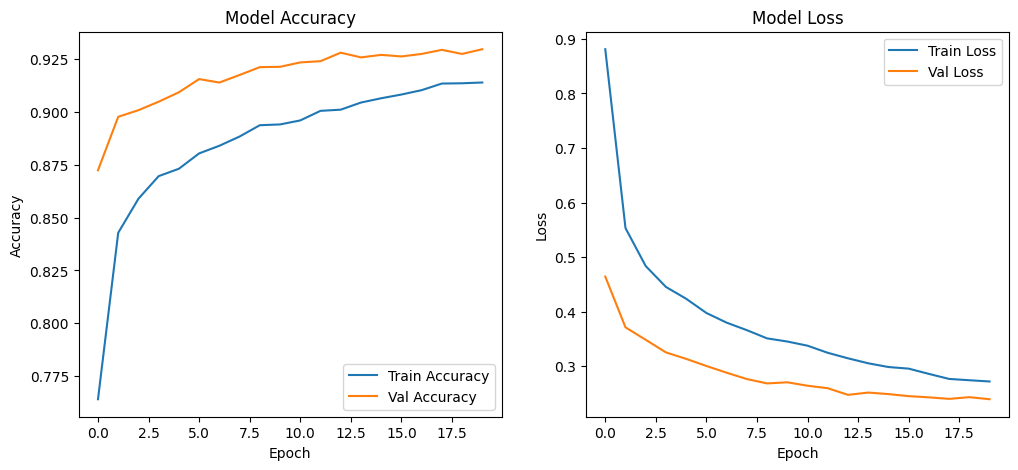

In [7]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [7]:
model.save("Plant_Disease_CNN_Model.h5")
print("✅ Model saved as Plant_Disease_CNN_Model.h5")


✅ Model saved as Plant_Disease_CNN_Model.h5


In [8]:
for layer in base_model.layers[-40:]:  # unfreeze last 40 layers
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)


Epoch 1/5
1695/1695 ━━━━━━━━━━━━━━━━━━━━ 2008s 1s/step - accuracy: 0.8319 - loss: 0.5786 - val_accuracy: 0.9190 - val_loss: 0.2875
Epoch 2/5
1695/1695 ━━━━━━━━━━━━━━━━━━━━ 1913s 1s/step - accuracy: 0.8887 - loss: 0.3753 - val_accuracy: 0.9245 - val_loss: 0.2605
Epoch 3/5
1695/1695 ━━━━━━━━━━━━━━━━━━━━ 1726s 1s/step - accuracy: 0.9032 - loss: 0.3275 - val_accuracy: 0.9293 - val_loss: 0.2435
Epoch 4/5
1695/1695 ━━━━━━━━━━━━━━━━━━━━ 1708s 1s/step - accuracy: 0.9111 - loss: 0.2945 - val_accuracy: 0.9306 - val_loss: 0.2323
Epoch 5/5
1695/1695 ━━━━━━━━━━━━━━━━━━━━ 1697s 1s/step - accuracy: 0.9180 - loss: 0.2707 - val_accuracy: 0.9338 - val_loss: 0.2237
